# Лабораторная работа

In [1]:
%%capture
!pip install torchmetrics
!pip install torchsummary

In [2]:
import os
from tqdm import tqdm

import numpy as np
import cv2
import torchvision.transforms as transforms
import torch
from torch import nn
from torch.nn import functional as F
import torchvision.transforms as T
from torchsummary import summary
from torchmetrics.functional import char_error_rate
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

import matplotlib.pyplot as plt
from PIL import Image
import textwrap

from itertools import groupby
import requests
from urllib.parse import urlencode

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Загрузка данных с Яндекс.Диска

In [4]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/adjYzzNayB1pag'


final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']


download_response = requests.get(download_url)

with open('photos.zip', 'wb') as f:
    f.write(download_response.content)

In [5]:
%%capture
! unzip -O utf8 photos.zip 

## Блок констант

In [6]:
TRAIN_DATA_PATH = "./CCPD2019-dl1/train"
TEST_DATA_PATH = "./CCPD2019-dl1/test"
BATCH_SIZE = 32
NUM_WORKERS = 2
EPOCHS = 10
FACTOR = 0.8
PATIENCE = 5
LEARNING_RATE = 3e-4

# Подготовка данных

## Класс датасета
1. В классе будем инициализиролвать путь к картинкам и композиционную функцию преобразования
2. В процессе инициализации зададим список всех файлов и обычных и закодированных меток.
3. Когда будем обращаться к фотографии, то будем:
- Делать картинки черно-белыми. Цвет в данной задаче не несёт никакой информации, потому что номера машин единообразны - белые буквы на синем(или почти синем) фоне; Также эта операция упростит вычисления.
- Делать картинки размером 128x32. Посмотрев размер примерно двух десятков изображений вручную, я определил, что это самый подходящий размер, потому что соотношение сторон картинки 4 к 1 позволяет сохранить пропорции знаков номера + не отходим от традиции задавать подобные вещи со степенями двойки.


In [7]:
class CCPDDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, transform=None):
        super(CCPDDataset, self).__init__()
        self.data_path = data_path
        self.__set_files_and_labels()
        self.transform = transform

    def __set_files_and_labels(self):
        # получаем все jpg файлы и их имена
        jpg_files = [file for file in os.listdir(self.data_path) if file.endswith('.jpg')]
        filenames = [filename.split('/')[-1] for filename in jpg_files]
        # получаем метки, т.е. номера из названия каждого файла, и формируем из них список
        labels = [filename.split('-')[-1][:-4] for filename in filenames]
        labels = [[letter for letter in word] for word in labels]
        # инициализируем список всех символов, встречающихся в номерах
        all_chars = [char for chars in labels for char in chars]
        # "Трениурем" LabelEncoder
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(all_chars)
        # создаём список закодированных номеров
        encoded_labels = np.array([self.label_encoder.transform(label) for label in labels]) + 1
        self.jpg_files = jpg_files
        self.labels = labels
        self.encoded_labels = encoded_labels
        self.num_chars = len(self.label_encoder.classes_)


    def __len__(self):
        return len(self.jpg_files)

    def __getitem__(self, index):
        label = self.encoded_labels[index]
        filename = self.jpg_files[index]
        
        # считываем картинку, приводим к размеру 128x32 и делаем её в градациях серого
        image = cv2.cvtColor(cv2.resize(cv2.imdecode(np.fromfile(os.path.join(self.data_path, filename), dtype=np.uint8), cv2.IMREAD_UNCHANGED), (128, 32)), cv2.COLOR_BGR2GRAY)

        if self.transform:
            image = self.transform(image)

        image = np.array(image)

        return {
            "image": torch.from_numpy(image),
            "label": torch.from_numpy(label),
        }

Используем следующие композиционные преобразования

In [8]:
transform = transforms.Compose([
     transforms.ToPILImage(),
     transforms.RandomRotation(degrees=(-5, 5)),
     transforms.ToTensor(), 
     transforms.Normalize((0.8), (0.8))
     ])

Зададим датасеты для обучающей и тестовой выборок

In [9]:
train_dataset = CCPDDataset(
    data_path=TRAIN_DATA_PATH,
    transform=transform
    )

test_dataset = CCPDDataset(
    data_path=TEST_DATA_PATH,
    transform=transform
    )


Проверим, корректно ли работает инициализация датасетов

In [10]:
print(f'В train_dataset находится {len(train_dataset)} элементов')
print(f'В test_dataset находится {len(test_dataset)} элементов')

В train_dataset находится 199980 элементов
В test_dataset находится 9999 элементов


Посмотрим на картинку из датасета

torch.Size([1, 32, 128])


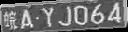

In [11]:
print(train_dataset[0]['image'].shape)
T.ToPILImage()(train_dataset[0]['image'])

In [12]:
train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        shuffle=True
)

test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        shuffle=False
)

# Созданиe модели и обучение модели

## Построение модели
Архитектура и параметры модели взяты из материалов README.md к этой лабораторной работе, а также из видеотуториала (https://www.youtube.com/watch?v=IcLEJB2pY2Y ). Fully-convolutional CNN и Bidirectional GRU. На выходе CTC-loss.

***Если метрики будут неудовлетворительными, то перепишу модель, поменяв архитектуру на более сложную.***

In [13]:
class CRNN(nn.Module):
    def __init__(self, num_chars):
        super(CRNN, self).__init__()
        # Сверточный слой
        self.conv = nn.Sequential(
            nn.Conv2d(1, 128, kernel_size=(3, 6), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Conv2d(128, 64, kernel_size=(3, 6), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 1)),
            nn.Conv2d(64, 32, kernel_size=(3, 6), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 1))
        )
        # линейный слой и дропаут
        self.linear_and_dropout = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2)
        )
        # рекуррентный слой
        self.gru = nn.GRU(64, 32, bidirectional=True, num_layers=2, dropout=0.25, batch_first=True)
        # выходной слой
        self.output = nn.Linear(64, num_chars + 1)

    def forward(self, image):
        bs = image.size()[0]
        self.bs = bs
        x = self.conv(image)

        x = x.permute(0, 3, 1, 2)
        x = x.view(image.size()[0], x.size(1), -1)


        x = self.linear_and_dropout(x)

        x, _ = self.gru(x)
        x = self.output(x)
        x = x.permute(1, 0, 2)

        return x

In [14]:
model = CRNN(num_chars=train_dataset.num_chars)
model.to(device)
summary(model, (1, 32, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 128, 32, 125]           2,432
              ReLU-2         [-1, 128, 32, 125]               0
         MaxPool2d-3          [-1, 128, 16, 62]               0
            Conv2d-4           [-1, 64, 16, 59]         147,520
              ReLU-5           [-1, 64, 16, 59]               0
         MaxPool2d-6            [-1, 64, 8, 59]               0
            Conv2d-7            [-1, 32, 8, 56]          36,896
              ReLU-8            [-1, 32, 8, 56]               0
         MaxPool2d-9            [-1, 32, 4, 56]               0
           Linear-10               [-1, 56, 64]           8,256
             ReLU-11               [-1, 56, 64]               0
          Dropout-12               [-1, 56, 64]               0
              GRU-13  [[-1, 56, 64], [-1, 2, 32]]               0
           Linear-14               [-

## Создание вспомогательных функций для обучения модели

Немного кастомизируем функцию потерь

In [15]:
def loss_func(model, y, y_pred):
    log_probs = F.log_softmax(y_pred, 2)
    input_lengths = torch.full(size=(model.bs,), fill_value=log_probs.size(0), dtype=torch.int32)
    label_lengths = torch.full(size=(model.bs,), fill_value=y.size(1), dtype=torch.int32)
    loss = nn.CTCLoss(blank=0)(log_probs, y, input_lengths, label_lengths)
    return loss


Сделаем функцию тренировочный шага (считаем потери на тренировочной выборке)

In [16]:
def train_step(model, dataloader, loss_fn, optimizer):
  
    model.train()

    train_loss = 0
    
    for data in tqdm(dataloader, total=len(dataloader)):
        for key, value in data.items():
            data[key] = value.to(device)

        X, y = data['image'], data['label']
        y_pred = model(X)

        loss = loss_fn(model, y, y_pred)
        train_loss += loss.item() 

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = train_loss / len(dataloader)

    return train_loss

Функция тестирующего шага (считаем loss на тесте + считаем accuracy)

In [17]:
def test_step(model, dataloader, loss_fn):

    model.eval() 
    test_loss = 0
    preditions = []
    
    with torch.inference_mode():
        for data in tqdm(dataloader, total=len(dataloader)):
            for key, value in data.items():
                data[key] = value.to(device)

            X, y = data['image'], data['label']
            test_pred = model(X)

            loss = loss_fn(model, y, test_pred)
            test_loss += loss.item()
            
            test_pred = tensors_to_original_numbers(test_pred, train_dataset.label_encoder)
            preditions.extend(test_pred)

    return preditions, test_loss / len(dataloader)

Функция для преобразования выходного тензора модели в корректный ответ

Из тензора делаем номер, т.е. Tensor([...]) -> '皖皖皖---AAA--99---333-XX--0--77' -> '皖A93X07'

In [18]:
def tensors_to_original_numbers(predictions, encoder):
    # делаем Tensor([...]) -> '皖皖皖---AAA--99---333-XX--0--77'
    predictions = predictions.permute(1, 0, 2)
    predictions = torch.softmax(predictions, 2)
    predictions = torch.argmax(predictions, 2)
    predictions = predictions.detach().cpu().numpy()
    original_predictions = []

    for _ in range(predictions.shape[0]):
        template = []
        for k in predictions[_, :]:
            k -= 1
            if k == -1:
                template.append("-")
            else:
                template.append(encoder.inverse_transform([k])[0])

        # делаем '皖皖皖---AAA--99---333-XX--0--77' -> '皖A93X07'
        original_number = ''.join(template)
        original_number = ''.join(key for key, group in groupby(original_number))
        original_number = original_number.replace("-", "")
        
        original_predictions.append(original_number)

    return original_predictions

## Обучение и оценка модели

Создаём модель, задаём оптимайзер и планировщик

In [19]:
model = CRNN(num_chars=train_dataset.num_chars)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=FACTOR, patience=PATIENCE, verbose=True)

Обучение модели и оценка функции потерь, точность и посимвольную ошибку

In [20]:
for epoch in range(EPOCHS):
    train_loss = train_step(model, train_loader, loss_func, optimizer)
    test_predicitons, test_loss = test_step(model, test_loader, loss_func)
    test_targets = [''.join(c) for c in test_dataset.labels]

    accuracy = metrics.accuracy_score(test_targets, test_predicitons)
    cer = char_error_rate(preds=test_predicitons, target=test_targets)
    
    print(f'Epoch={epoch} | Train Loss={train_loss}, Test Loss={test_loss}, Accuracy={accuracy}, CER={cer}')
    scheduler.step(test_loss)

100%|██████████| 313/313 [00:18<00:00, 16.71it/s]


Epoch=0 | Train Loss=2.097848557064533, Test Loss=2.9966083928799856, Accuracy=0.7268726872687269, CER=0.050476476550102234


100%|██████████| 313/313 [00:19<00:00, 16.06it/s]


Epoch=1 | Train Loss=0.07829423358850181, Test Loss=3.610079801120697, Accuracy=0.9058905890589058, CER=0.016630234196782112


100%|██████████| 313/313 [00:20<00:00, 15.33it/s]


Epoch=2 | Train Loss=0.026252151748053728, Test Loss=3.79644176906671, Accuracy=0.9375937593759376, CER=0.010443901643157005


100%|██████████| 313/313 [00:20<00:00, 15.33it/s]


Epoch=3 | Train Loss=0.01686042222694494, Test Loss=4.001425634938688, Accuracy=0.9490949094909491, CER=0.008400839753448963


100%|██████████| 313/313 [00:21<00:00, 14.57it/s]


Epoch=4 | Train Loss=0.012688069848637096, Test Loss=4.097201842469529, Accuracy=0.9590959095909591, CER=0.00677210558205843


100%|██████████| 313/313 [00:20<00:00, 14.96it/s]


Epoch=5 | Train Loss=0.010245140329045244, Test Loss=4.196984425139504, Accuracy=0.965996599659966, CER=0.0055862730368971825


100%|██████████| 313/313 [00:21<00:00, 14.59it/s]


Epoch=6 | Train Loss=0.008719302984385285, Test Loss=4.006277650309066, Accuracy=0.9680968096809681, CER=0.005171945784240961
Epoch 00007: reducing learning rate of group 0 to 2.4000e-04.


100%|██████████| 313/313 [00:21<00:00, 14.87it/s]


Epoch=7 | Train Loss=0.006743327078474685, Test Loss=4.050089642643548, Accuracy=0.9685968596859686, CER=0.00518623273819685


100%|██████████| 313/313 [00:20<00:00, 15.27it/s]


Epoch=8 | Train Loss=0.006219139039649163, Test Loss=4.138837491361478, Accuracy=0.971997199719972, CER=0.004614747129380703


100%|██████████| 313/313 [00:22<00:00, 14.08it/s]


Epoch=9 | Train Loss=0.005597614310808713, Test Loss=4.054983465054545, Accuracy=0.9750975097509751, CER=0.0039861127734184265


# Подсчёт метрик

In [21]:
print(f'Accuracy: {round(accuracy * 100, 2)}%')
print(f'CER     : {round(cer.item() * 100, 2)}%')


Accuracy: 97.51%
CER     : 0.4%


**Точность 97.51% - отличный результат, модель почти не ошибается, когда распознаёт номера**

**CER 0.4% тоже хороший результат, ошибочно определить всего лишь 4 символа из 1000 - почти идеальный результат**

# Анализ ошибок модели

Будем анализировать ошибки по показателю CER. Составим отсортированный по убыванию словарь с этой метрикой и посмотрим на 25 первых картинок и предсказанные для них метки

Словарь с CER для каждой картинки

In [22]:
cer_dict = {}
for i in range(len(test_dataset)):
    cer = char_error_rate(preds=test_predicitons[i], target=test_targets[i]) 
    cer_dict[i] = cer.item()
cer_dict = {k: v for k, v in reversed(sorted(cer_dict.items(), key=lambda x: x[1]))}

Топ-25 худших по CER картинок

In [23]:
top_25_keys = list(cer_dict.keys())[:25]

paths = []
titles = []

for i in top_25_keys:
    titles.append(f'True: {test_targets[i]}\nPred: {test_predicitons[i]}')
    paths.append(test_dataset.jpg_files[i])

images_to_show = [Image.open(os.path.join(TEST_DATA_PATH, path)) for path in paths]

Функция для отображения картинок

In [24]:
def show_images(images, titles):
    num_images = 25

    fig, axes = plt.subplots(5, 5, figsize=(15, 15))

    for i, ax in enumerate(axes.flat):
        if i < num_images:
            ax.imshow(images[i])
            ax.axis('off')
            title = titles[i]
            title=textwrap.wrap(title, 16)
            title="\n".join(title)
            ax.set_title(title, fontsize=16); 

    plt.tight_layout()
    plt.show()


Сами картинки

<ipython-input-24-4da9be5c67a3>:16: UserWarning: Glyph 30358 (\N{CJK UNIFIED IDEOGRAPH-7696}) missing from current font.
  plt.tight_layout()
<ipython-input-24-4da9be5c67a3>:16: UserWarning: Glyph 28189 (\N{CJK UNIFIED IDEOGRAPH-6E1D}) missing from current font.
  plt.tight_layout()
<ipython-input-24-4da9be5c67a3>:16: UserWarning: Glyph 36195 (\N{CJK UNIFIED IDEOGRAPH-8D63}) missing from current font.
  plt.tight_layout()
<ipython-input-24-4da9be5c67a3>:16: UserWarning: Glyph 33487 (\N{CJK UNIFIED IDEOGRAPH-82CF}) missing from current font.
  plt.tight_layout()
<ipython-input-24-4da9be5c67a3>:16: UserWarning: Glyph 20113 (\N{CJK UNIFIED IDEOGRAPH-4E91}) missing from current font.
  plt.tight_layout()
<ipython-input-24-4da9be5c67a3>:16: UserWarning: Glyph 20140 (\N{CJK UNIFIED IDEOGRAPH-4EAC}) missing from current font.
  plt.tight_layout()
<ipython-input-24-4da9be5c67a3>:16: UserWarning: Glyph 38397 (\N{CJK UNIFIED IDEOGRAPH-95FD}) missing from current font.
  plt.tight_layout()
<ipyth

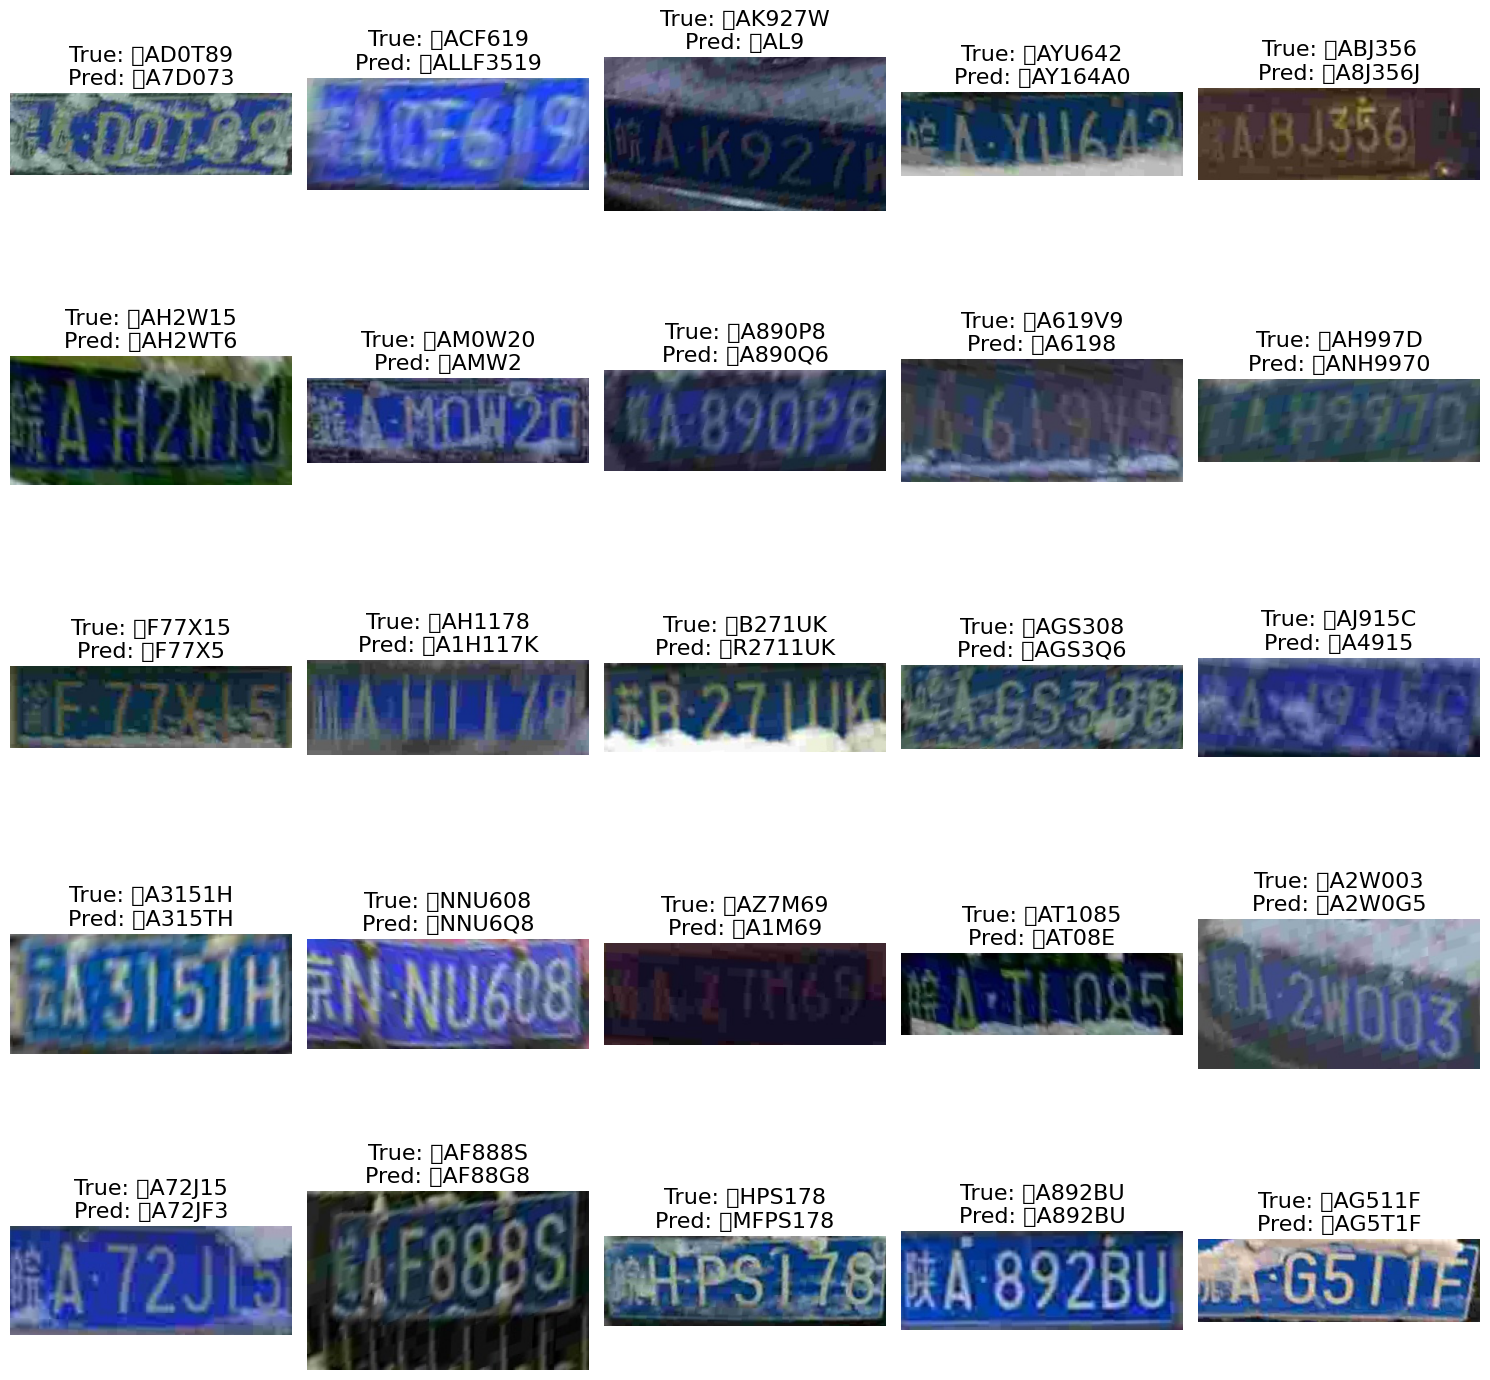

In [26]:
show_images(images_to_show, titles)

По данным 25 картинкам следует, что модель делает ошибки в распознании символов по следующему ряду причин:
1. Где-то хромает качество картинки
2. Где-то не получается верно определить из-за шума - снега на номерах
3. Возможно, где-то влияет угол фотографии

Можно увеличить точность модели следующим образом:
1. Использовать большее разрешение для фотографии, которую подаём на вход модели
2. Использовать аугментацию - добавление шума, чтобы имитировать снег на номерах, добавление большего поворота, имитируя угол фотографии
3. Усложнить архитектуру модели, добавив связей и слоёв или реализовав какую-нибудь модель из статьи(paper replicating).


